Multiplicative Attention

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
import time
from datasets import load_dataset, DatasetDict
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from indicnlp.tokenize import indic_tokenize

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Set seed for reproducibility
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cpu


In [34]:
# 1. Data Loading
# Load the full dataset
dataset = load_dataset("opus100", "en-si")

# Reduce the training set to 10,000 samples
# Otherwise I can't finish and submit this assientment!!!
# I try to maintain the ratio of 0.2 (traning set and test set)
small_train_dataset = dataset["train"].select(range(10000))
small_test_dataset = dataset["test"].select(range(2000))
small_validation_dataset = dataset["validation"].select(range(2000))

dataset = DatasetDict({
    "train": small_train_dataset,
    "test": small_test_dataset,
    "validation": small_validation_dataset
})

# Verify the new sizes
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})


In [35]:
# 2. Preprocessing: Tokenization and Numericalization
SRC_LANGUAGE = "en"
TRG_LANGUAGE = "si"

token_transform = {}
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

def sinhala_tokenizer(text):
    return indic_tokenize.trivial_tokenize(text, lang='si')

token_transform[TRG_LANGUAGE] = sinhala_tokenizer

# Function to yield tokenized sentences from training data
def yield_tokens(data, language):
    for data_sample in data:
        yield token_transform[language](data_sample["translation"][language])

# Define special tokens
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

# Build vocabulary from training set
vocab_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln] = build_vocab_from_iterator(
        yield_tokens(dataset["train"], ln),
        min_freq=2,
        specials=special_symbols,
        special_first=True
    )

# Set default index for unknown words
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

# Helper function for sequential transformations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# Function to add BOS/EOS tokens and convert to tensor
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# Define text transformation pipeline
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln],
                                               vocab_transform[ln],
                                               tensor_transform)

# Function to collate data samples into batch tensors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []

    for sample in batch:
        src_text = sample["translation"][SRC_LANGUAGE].rstrip("\n")
        trg_text = sample["translation"][TRG_LANGUAGE].rstrip("\n")

        processed_src = text_transform[SRC_LANGUAGE](src_text)
        processed_trg = text_transform[TRG_LANGUAGE](trg_text)

        src_batch.append(processed_src)
        trg_batch.append(processed_trg)
        src_len_batch.append(processed_src.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first=True)

    src_len_batch = torch.tensor(src_len_batch, dtype=torch.long)
    sorted_src_len, sorted_idx = torch.sort(src_len_batch, descending=True)
    src_batch = src_batch[sorted_idx]
    trg_batch = trg_batch[sorted_idx]

    return src_batch, sorted_src_len, trg_batch


In [36]:
# Create data loaders
BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(dataset["train"], batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_loader = torch.utils.data.DataLoader(dataset["validation"], batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader  = torch.utils.data.DataLoader(dataset["test"], batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
train_loader_length = len(train_loader)

In [37]:
# 3. Attention Mechanism: Multiplicative Attention
class MultiplicativeAttention(nn.Module):
    def __init__(self, d1, d2):
        super().__init__()
        self.W = nn.Linear(d2, d1, bias=False)  # Weight matrix W

    def forward(self, s, h):
        """
        Computes Multiplicative Attention with softmax and context vector.

        Parameters:
        s (Tensor): Query vector of shape (batch_size, d1)
        h (Tensor): Key vectors of shape (batch_size, seq_len, d2)

        Returns:
        Tensor: Context vector of shape (batch_size, d2)
        Tensor: Attention weights of shape (batch_size, seq_len)
        """
        Wh = self.W(h)  # Transform h using W
        attention_scores = torch.bmm(Wh, s.unsqueeze(2)).squeeze(2)  # [batch_size, seq_len]
        attention_weights = F.softmax(attention_scores, dim=1)
        context = torch.bmm(attention_weights.unsqueeze(1), h).squeeze(1)
        return context, attention_weights


In [38]:
# 4. Seq2Seq Model with Attention
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, src_len, trg):
        batch_size = trg.size(0)
        trg_len = trg.size(1)

        encoder_outputs, encoder_hidden = self.encoder(src, src_len)
        hidden = encoder_hidden
        output = torch.zeros(batch_size, trg_len, self.decoder.output_dim).to(self.device)
        input = trg[:, 0]

        for t in range(1, trg_len):
            context, _ = self.decoder.attention(hidden[-1], encoder_outputs)
            decoder_output, hidden = self.decoder(input, hidden, encoder_outputs, context)
            output[:, t, :] = decoder_output
            input = trg[:, t]

        return output

# Encoder Class (Unidirectional GRU)
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_len):
        embedded = self.dropout(self.embedding(src))
        packed = pack_padded_sequence(embedded, src_len, batch_first=True, enforce_sorted=False)
        outputs, hidden = self.rnn(packed)
        outputs, _ = pad_packed_sequence(outputs, batch_first=True)
        return outputs, hidden

# Decoder Class
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, n_layers, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs, context):
        embedded = self.dropout(self.embedding(input).unsqueeze(1))
        rnn_output, hidden = self.rnn(embedded, hidden)
        context, attention = self.attention(hidden[-1], encoder_outputs)
        output = torch.cat((rnn_output.squeeze(1), context), dim=1)
        output = self.fc_out(output)
        return output, hidden


In [39]:
# Define train function
def train(model, data_loader, optimizer, criterion, clip, loader_length):
    model.train()
    epoch_loss = 0

    for i, batch in enumerate(data_loader):
        src, src_len, trg = batch
        src, src_len, trg = src.to(device), src_len.to(device), trg.to(device)

        optimizer.zero_grad()
        output = model(src, src_len, trg)

        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)

        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / loader_length





# Validation function
def evaluate(model, data_loader, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for batch in data_loader:
            src, src_len, trg = batch
            src, src_len, trg = src.to(device), src_len.to(device), trg.to(device)

            output = model(src, src_len, trg)
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(data_loader)

In [40]:
# Initialize model and components
input_dim = len(vocab_transform[SRC_LANGUAGE])
output_dim = len(vocab_transform[TRG_LANGUAGE])
hidden_dim = 256
n_layers = 2
dropout = 0.35

encoder = Encoder(input_dim, hidden_dim, n_layers, dropout)
attention = MultiplicativeAttention(hidden_dim, hidden_dim)  # d1 and d2 both set to hidden_dim
decoder = Decoder(output_dim, hidden_dim, n_layers, dropout, attention)
model = Seq2Seq(encoder, decoder, device).to(device)

In [41]:

# 5. Optimizer and Loss Function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# Training loop
clip = 1
epochs = 10
best_valid_loss = float('inf')

train_losses = []
valid_losses = []

for epoch in range(epochs):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model-MultiAttention.pt')

    end_time = time.time()

    print(f"Epoch: {epoch+1:02} | Time: {end_time - start_time:.2f}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:.3f} | Valid PPL: {math.exp(valid_loss):7.3f}")

Epoch: 01 | Time: 122.08s
	Train Loss: 4.968 | Train PPL: 143.677
	Valid Loss: 4.280 | Valid PPL:  72.232
Epoch: 02 | Time: 133.67s
	Train Loss: 4.255 | Train PPL:  70.477
	Valid Loss: 4.074 | Valid PPL:  58.765
Epoch: 03 | Time: 137.21s
	Train Loss: 3.940 | Train PPL:  51.403
	Valid Loss: 3.976 | Valid PPL:  53.317
Epoch: 04 | Time: 131.80s
	Train Loss: 3.652 | Train PPL:  38.558
	Valid Loss: 3.949 | Valid PPL:  51.899
Epoch: 05 | Time: 136.12s
	Train Loss: 3.383 | Train PPL:  29.473
	Valid Loss: 3.942 | Valid PPL:  51.510
Epoch: 06 | Time: 135.21s
	Train Loss: 3.137 | Train PPL:  23.027
	Valid Loss: 3.953 | Valid PPL:  52.087
Epoch: 07 | Time: 126.36s
	Train Loss: 2.896 | Train PPL:  18.106
	Valid Loss: 3.972 | Valid PPL:  53.098
Epoch: 08 | Time: 126.17s
	Train Loss: 2.684 | Train PPL:  14.644
	Valid Loss: 4.019 | Valid PPL:  55.660
Epoch: 09 | Time: 123.79s
	Train Loss: 2.491 | Train PPL:  12.074
	Valid Loss: 4.058 | Valid PPL:  57.870
Epoch: 10 | Time: 123.69s
	Train Loss: 2.312 |

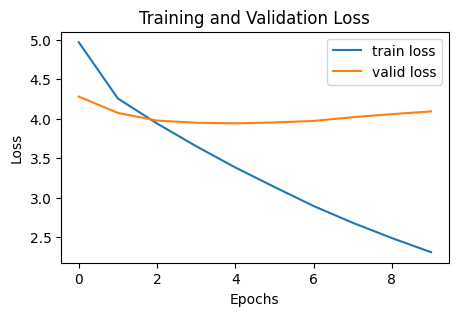

In [42]:
# Plotting training and validation losses
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label='train loss')
ax.plot(valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

In [43]:
model.load_state_dict(torch.load('best-model-MultiAttention.pt'))
test_loss = evaluate(model, test_loader, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.948 | Test PPL:  51.822 |


C:\Users\Arunya Senadeera\AppData\Local\Temp\ipykernel_14244\2645419010.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45)
C:\Users\Arunya Senadeera\AppData\Local\Temp\ipykernel_14244\2645419010.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)
c:\Users\Arunya Senadeera\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3466 (\N{SINHALA LETTER IIYANNA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Arunya Senadeera\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Sinhala natively.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Arunya Senadeera\AppData\Local\P

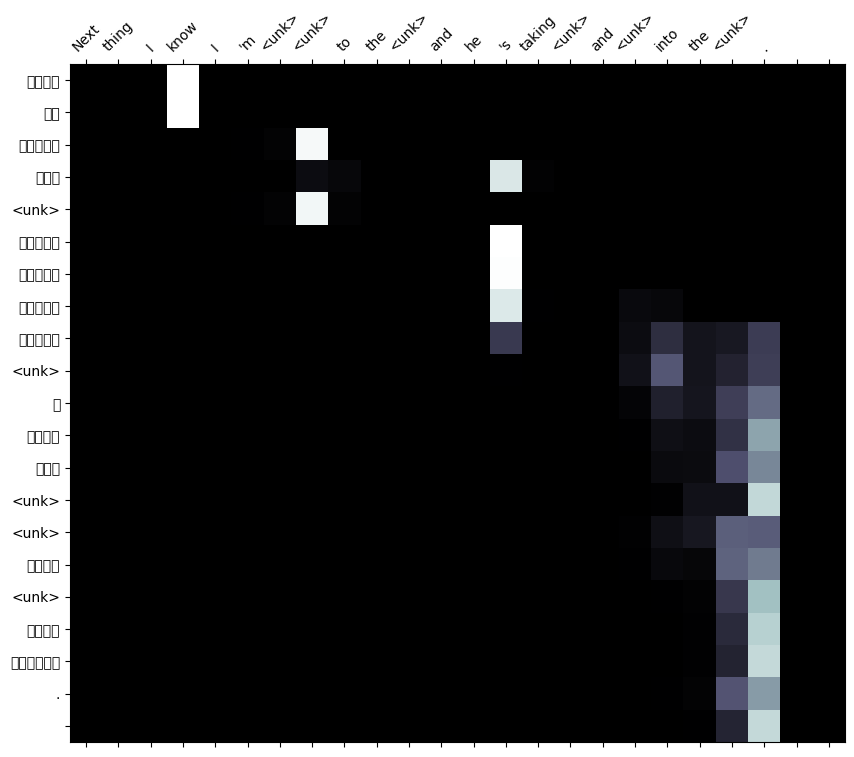

In [44]:
import matplotlib.ticker as ticker

 #Function to display attention
def display_attention(sentence, translation, attention):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=10)
    
    y_ticks = [''] + translation
    x_ticks = [''] + sentence 
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

# Function to get attention weights for a sample
def get_attention(model, src, src_len, trg):
    model.eval()
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src, src_len)
        trg_len = trg.shape[1]
        attentions = torch.zeros(trg_len - 1, src_len)  # Store attention weights

        output = torch.zeros(1, trg_len, model.decoder.output_dim).to(device)
        input = trg[:, 0]  # Start with <sos>

        for t in range(1, trg_len):
            context, attention = model.decoder.attention(hidden[-1], encoder_outputs)
            output[:, t, :], hidden = model.decoder(input, hidden, encoder_outputs, context)
            attentions[t - 1] = attention.squeeze(0).cpu()  # Save attention weights
            input = trg[:, t]  # Next input is current target token

    return attentions

# Example: Visualize attention for a sample from the test set
def visualize_attention(model, data_loader, vocab_transform, src_lang, trg_lang, index=0):
    src, src_len, trg = next(iter(data_loader))  # Get a batch
    src, src_len, trg = src[index:index+1].to(device), src_len[index:index+1].to(device), trg[index:index+1].to(device)

    # Get attention weights
    attentions = get_attention(model, src, src_len, trg)

    # Convert token IDs to words
    src_tokens = [vocab_transform[src_lang].get_itos()[i] for i in src[0].cpu().numpy()]
    trg_tokens = [vocab_transform[trg_lang].get_itos()[i] for i in trg[0].cpu().numpy()]

    # Remove <sos> and <eos> tokens
    src_tokens = src_tokens[1:-1]  # Remove <sos> and <eos>
    trg_tokens = trg_tokens[1:-1]  # Remove <sos> and <eos>

    # Display attention
    display_attention(src_tokens, trg_tokens, attentions)

# Visualize attention for the first sample in the test set
visualize_attention(model, test_loader, vocab_transform, SRC_LANGUAGE, TRG_LANGUAGE, index=0)

In [47]:
#7. Inferance from the model
import torch

# Load the saved model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('best-model-MultiAttention.pt', map_location=device))
model.to(device)
model.eval()  # Set model to evaluation mode

def translate_sentence(model, sentence, text_transform, SRC_LANGUAGE, TRG_LANGUAGE, vocab_transform, device, max_length=50):
    model.eval()
    
    # Preprocess input sentence
    src_tensor = text_transform[SRC_LANGUAGE](sentence).unsqueeze(0).to(device)  # Shape: [1, seq_len]
    src_len = torch.tensor([src_tensor.shape[1]], dtype=torch.long).to(device)  # Get source length

    # Create a tensor for the generated output, starting with <sos>
    trg_indexes = [SOS_IDX]
    
    with torch.no_grad():
        for _ in range(max_length):
            trg_tensor = torch.tensor(trg_indexes).unsqueeze(0).to(device)  # Shape: [1, current_seq_len]
            
            # Forward pass through the model
            output = model(src_tensor, src_len, trg_tensor)  # Now passing src_len
            
            # Get the predicted token (last token in sequence)
            pred_token = output.argmax(2)[:, -1].item()
            
            # Append to the output sequence
            trg_indexes.append(pred_token)
            
            # Stop if <eos> token is generated
            if pred_token == EOS_IDX:
                break

    # Convert token indexes to words
    trg_tokens = [vocab_transform[TRG_LANGUAGE].get_itos()[idx] for idx in trg_indexes[1:]]  # Skip <sos>
    return " ".join(trg_tokens)

# Example Usage:
sentence = "Hello, see you later"  # Replace with any English sentence
translation = translate_sentence(model, sentence, text_transform, SRC_LANGUAGE, TRG_LANGUAGE, vocab_transform, device)
print(f"Translated Sentence: {translation}")


Translated Sentence: <unk> හෙලෝ , , ඔයා ඔයා <unk> <unk> <eos>
